In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
def gauss(x, t, nr, u, dx, Nx):
    # Calcula x0 con condiciones periódicas
    x0 = (x - u * t) % ((Nx - 1) * dx)
    # Calcula la gaussiana centrada en 51*dx    
    C = 10 * np.exp((-(x0-51*dx)**2)/((nr*dx)**2))
    return C

In [3]:
def rectg(x, t, u, dx, Nx, co=10):
    # Calcula x0 con condiciones periódicas
    x0 = (x - u * t) % ((Nx - 1) * dx)
    # Define el pulso rectangular entre 50*dx y 52*dx
    a = x0 >= 50*dx  
    b = x0 <= 52*dx
    C = np.where(a & b, co, 0)
    return int(C)  # Si se espera un escalar, o mantener np.where si es para arrays

In [4]:
u = 10  # Vel advección en m/s
Nx = 101  # puntos en la malla
dx = 500  # Espaciado de grid (m)
dt = 25 # delta de tiempo
nr = 10 # nr

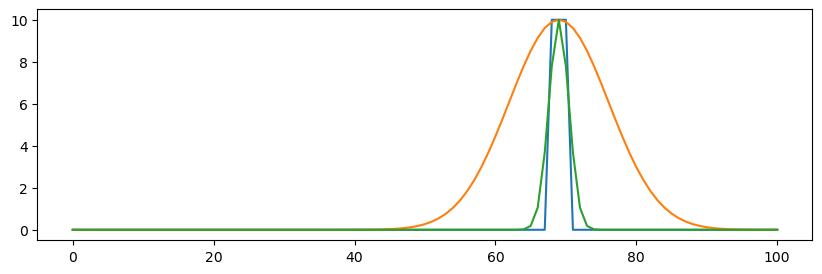

In [5]:
plt.figure(figsize=(10,3))
plt.plot([rectg(e*dx, 900, u, dx, Nx, co=10) for e in range(Nx)])    
plt.plot([gauss(e*dx, 900, nr, u, dx, Nx) for e in range(Nx)])
plt.plot([gauss(e*dx, 900, 2, u, dx, Nx) for e in range(Nx)])   

In [6]:
dt = 60 # delta de tiempo

In [7]:
X=[e*dx for e in range(Nx)]
T=[e*dt for e in range(Nx*3)] # *n: cantidad de tiempos
CFL= dt*u/dx; print(CFL)
nr=10 #10 #2

1.2


In [8]:
A=[]
for t in T:    
    A.append([gauss(e, t, nr, u, dx, Nx) for e in X]) # guarda analitica 

In [9]:
M=[]
for t in T[:]:     
    if t==0: 
        Cn=[gauss(e, t, nr, u, dx, Nx) for e in X]
        M.append(Cn)
        continue
    Cnp1 = np.zeros_like(X, dtype=float)
    for j in range(0, Nx): 
        Cnp1[j] = Cn[j] - (u*dt/dx) * (Cn[j] - Cn[j-1])
    M.append(Cnp1)
    Cn = Cnp1.copy()    

In [10]:
import xarray as xr
import pandas as pd

In [11]:
data_3d = np.tile(np.array(M)[:, np.newaxis, : ], (1,2,1)) 

In [12]:
# Coordenadas de ejemplo (ajusta según tus datos reales)
X = np.arange(0, Nx, 1)  # 100 valores de longitud
Y = np.arange(-dx/2, dx+dx/2,dx)       # 3 latitudes (pueden ser nombres o valores)
time = pd.Timestamp('2020-01-01') + pd.to_timedelta(T, unit='s')

In [13]:
ds = xr.Dataset({"conc_unids": (["time","Y", "X"], data_3d),},
                coords={"time": time,"X": X,"Y": Y},)

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

In [15]:
plt.rcParams.update({'font.size': 11})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [16]:
p1=[round((e-1)/3,1) for e in np.logspace(0,1.6,15)][1:]
p2=[e*-1 for e in p1[:]]
p2.extend(p1)
nlevel=sorted(np.array(p2))
nlevel=[-12, -10, -8, -6, -4, -3, -2, -1.5, -1.2, -0.9, -0.6, -0.4, -0.2, 
        -0.1, -0.05,0.05,0.1, 0.2, 0.4, 0.6, 0.9, 1.2, 1.5, 2, 3, 4, 6, 8, 10, 12]

In [17]:
original_cmap = plt.get_cmap('coolwarm') #RdBu_r #bwr
colors = original_cmap(np.linspace(0, 1, 256))
mid_point = len(colors) // 2
colors[mid_point - 1 : mid_point + 1] = [0, 0, 0, 1]  # Negro (RGBA)
custom_cmap = LinearSegmentedColormap.from_list('custom_bwr', colors)

In [18]:
metodo='Eule Backward'

In [19]:
ti=5
ds_t0 = ds.isel(time=ti) 
val_lim=25

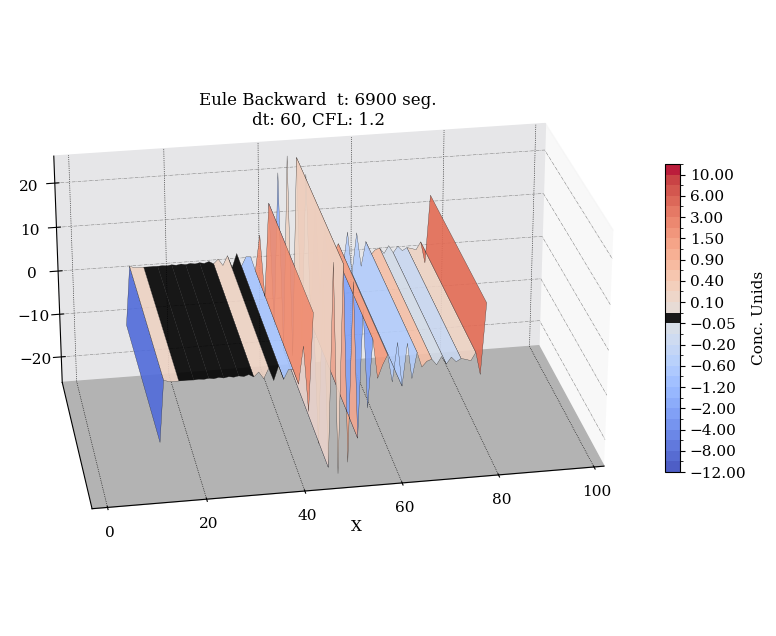

In [20]:
# Crear figura 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
# Obtener coordenadas de latitud y longitud
lon = ds_t0.X.values
lat = ds_t0.Y.values
# Crear una malla 2D para el plot 3D
lon_grid, lat_grid = np.meshgrid(lon, lat)
# Obtener los valores de la variable en t=0
data = ds_t0["conc_unids"].values  # Forma (lat, lon)
data[data > val_lim] = np.nan
data[data < -val_lim] = np.nan
ax.view_init(elev=25, azim=-100) 
ax.set_box_aspect([2, 1.1, 1])
# Graficar superficie 3D
norm = BoundaryNorm(boundaries=nlevel, ncolors=256)
# Superficie con paleta 'Spectral' y niveles
surf = ax.plot_surface(lon_grid, lat_grid, data,cmap=custom_cmap, norm=norm,
                       edgecolor='.1', alpha=0.9,lw=.2,)
ax.autoscale(enable=False)
ax.set_zlim(-val_lim,val_lim)
ax.set_xlim(-1, 100)
ax.set_ylim(-dx/2,dx/2)
# Añadir barra de colores
fig.colorbar(surf, ax=ax, shrink=0.5, label='Conc. Unids',ticks=nlevel[::2])
# Etiquetas de ejes
ax.set_xlabel('X')
ax.set_yticks([])
ax.xaxis._axinfo["grid"].update({'color': 'k', 'linestyle': ':', 'alpha': 0.2,'linewidth':.5})
ax.zaxis._axinfo["grid"].update({'color': '.5', 'linestyle': '-.', 'alpha': 0.1,'linewidth':.39})
ax.set_title('%s  t: %s seg.\ndt: %s, CFL: %s'%(metodo,ti*dt,dt,CFL),y=.87,fontsize=12)
# --- Cambiar el color de fondo del espacio 3D ---
ax.zaxis.set_pane_color((0.7, 0.7, 0.7, 1.0))  # Fondo del plano YZ (lon)
ax.yaxis.set_pane_color((0.9, 0.9, 0.91, 1.0)) # Fondo del plano XY (altura)
#
fig.savefig("figura_completa3.png", dpi=300, bbox_inches='tight')

In [21]:
# 2. Recortas con Pillow (50% superior)
img = Image.open("figura_completa3.png")
width, height = img.size
# Calcular márgenes para recortar 1/4 arriba y 1/4 abajo (queda el 50% central)
espacio=7
top = height // espacio
bottom = (espacio-1) * height // espacio
# Recortar imagen (left, upper, right, lower)
central_half = img.crop((0, top, width, bottom))
# Guardar imagen recortada
central_half.save("figur8.png")